# Case 2: First trial
27.1.2022, Sakari Lukkarinen<br>
[Metropolia UAS](https://www.metropolia.fi/en) <br>

Gajalakshan Chandrasegaran, Dhruval Kikani<br>


## 1. Introduction

The objective of this case study is to create at Convolutional Neural Network model to predict whether or not a patient has pneumonia or not, based on x-ray images. For this report, we have created three separate models for this prediction. This first model is our chosen best out of the three, though Model 3 is very close to the performance of this model as well.

This Notebook is the first trial to use Kaggle Notebook with Case 2 dataset. It differs significantly from the other case study, although it does not affect its performance as a model. Based on the results of the training and verification data, this was a our very best option as a model.It works really well with the data, after running the test data, it became clear that this model has great potential and that it performed very well in predicting the experimental data. 


In [35]:
%pylab inline
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
print("tensorflow", tf.__version__)

Populating the interactive namespace from numpy and matplotlib
tensorflow 2.8.0


## 2.Training settings

In [36]:
batch_size = 32
target_size = (180,180)
img_height = 180
img_width = 180

## 3.DataSet

The dataset is a collection of x-ray images labeled "NORMAL" for a healthy patient and "PNEUMONIA" for a pneumonia patient. Because the training and testing data were already neatly segregated into distinct folders, there was no need to manually partition the data into training and testing sets.

In [37]:
train_dir = r'C:\Users\dkika\Downloads\archive (1)\chest_xray\train'
test_dir = r'C:\Users\dkika\Downloads\archive (1)\chest_xray\test'

## 4. Preprocessing

**Training**

In [38]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = target_size,
  batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


**Validation**

In [39]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = target_size,
  batch_size = batch_size)



Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


**Test**

In [40]:
# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size = target_size,
  batch_size = batch_size)

Found 624 files belonging to 2 classes.


**Speeding up**

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5. Modeling

For this model, we used a data augmentation layer followed by normalization layer, with three Conv2D() layers. Each hidden layer utilises Dropout() to reduce overfitting. For each hidden layer, we used the ReLU activation function, and sigmoid activation function for the output layer, as this is a binary classification and sigmoid works well to illustrate that. 

We used binary_crossentropy for the loss function. For the optimizer, we tested both RMSprop and Adam, and came to the conclusion that while Adam gave us a better overall accuracy, specificity and sensitivity in the training and validation datasets.

For metrics, we used accuracy as before, with the addition of SpecificityAtSensitivity() and SensitivityAtSpecificity. This was done because, despite multiple efforts to use sklearn classification_report to generate accuracy, sensitivity, and specificity data, this was not compatible with the dataset generator we used in this case study. 

### Creating Normalization Layer and Data augmentation layer

In [42]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ])

In [43]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(target_size, 3))

### Creating the Model

In [44]:
model = Sequential([
    data_augmentation,
    normalization_layer,
    
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy', tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5)])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

## 6. Training

Only 5 epochs are really necessary to achieve an acceptable result. This model was fast stabilizing and achieving a plateau of values for all measurements, so further epochs were considered unnecessary. 

In [45]:
%%time
E = 5
h = model.fit(      
      train_ds,
      validation_data = val_ds,
      verbose = 0, 
      epochs = E)

Wall time: 9min 26s


## 7. Evaluation and Results

### Training and Validation Accuracy

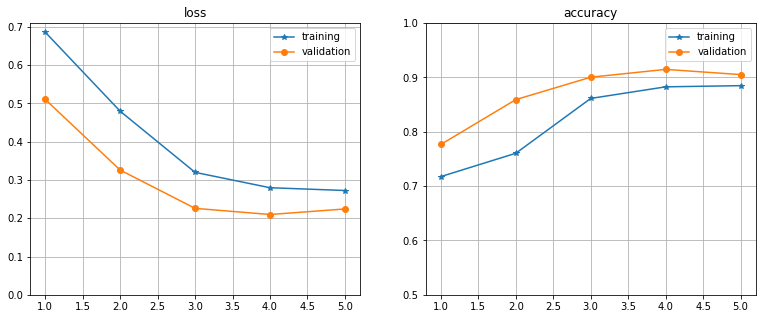

In [46]:
loss = h.history['loss']
acc = h.history['accuracy']
val_loss = h.history['val_loss']
val_acc = h.history['val_accuracy']
x = arange(len(loss)) + 1

figure(figsize(13, 5))
subplot(1, 2, 1)
plot(x,loss, '*-', label = 'training')
plot(x, val_loss, 'o-', label = 'validation')
title('loss')
ylim(0, )
legend()
grid()

subplot(1, 2, 2)
plot(x, acc, '*-', label = 'training')
plot(x, val_acc, 'o-', label = 'validation')
title('accuracy')
ylim(0.5, 1.0)
legend()
grid()

In [47]:
results = model.evaluate(val_ds)
print('The validation accuracy is :', results[1]*100, '%')
print('The validation specificity is :', results[2]*100, '%')
print('The validation sensitivity is :', results[3]*100, '%')

33/33 [==============================] - 6s 176ms/step - loss: 0.2243 - accuracy: 0.9051 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9951
The validation accuracy is : 90.50815105438232 %
The validation specificity is : 100.0 %
The validation sensitivity is : 99.50617551803589 %


###  Evaluation

Even with unknown data, the model worked admirably, as shown below. Although the total accuracy is lower than the training and validation sets, the specificity and sensitivity are both over 90%, indicating that the model was not overfitted for the validation datasets.

In [48]:
results = model.evaluate(test_ds)
print('The testing accuracy is :', results[1]*100, '%')
print('The testing specificity is :', results[2]*100, '%')
print('The testing sensitivity is :', results[3]*100, '%')

20/20 [==============================] - 5s 201ms/step - loss: 0.3591 - accuracy: 0.8237 - specificity_at_sensitivity_2: 0.9957 - sensitivity_at_specificity_2: 0.9641
The testing accuracy is : 82.37179517745972 %
The testing specificity is : 99.5726466178894 %
The testing sensitivity is : 96.4102566242218 %


## 8. Conclusions

Based on the training and validation data, this was our top performing model overall. The model's accuracy, sensitivity, and specificity were all excellent, and it also performed admirably with test data, though with lower accuracy than the training and validation sets. This is to be expected, given that the model has never seen test data before.
Although it has lot of room to improve as a model.
laslty these results are after watching many models on the interent and trying to understand different ideas as a result it is a mix of what we have overally learned and gained knowlegde about.